# Training StyleGAN-Canvas

This is a notebook for training [StyleGAN-Canvas](https://github.com/jasper-zheng/StyleGAN-Canvas).  

Author: Jasper Zheng (Shuoyang)

## Setup  

Please make sure you're running a GPU runtime.  

In [1]:
import torch

torch.cuda.is_available()

True

#### Clone Repo and Install Dependencies  

In [2]:
!git clone https://github.com/jasper-zheng/StyleGAN-Canvas.git  
%cd StyleGAN-Canvas
!pip install -r ./requirements.txt

!pip uninstall jax jaxlib -y
!pip install "jax[cuda11_cudnn805]==0.3.10" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


fatal: destination path 'StyleGAN-Canvas' already exists and is not an empty directory.
/notebooks/StyleGAN-Canvas
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.5/28.5 MB 51.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 41.8 MB/s eta 0:00:0000:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 104.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/204.8 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9

#### Download and Prepare Dataset  

Download the [FFHQ](https://github.com/NVlabs/ffhq-dataset) (Unaligned) 256x256

In [ ]:
%cd ./StyleGAN-Canvas
!gdown 1Sqd0e_O7-ksCwt-4Kun6qVjkL7L8L6nG

The pre-process pipeline is defined in `./training/pipeline.py`, edit the code to change the pipeline. We use gaussian filter for example.

In [3]:
%cd ./StyleGAN-Canvas

/notebooks/StyleGAN-Canvas


In [ ]:
dataset_file = '/notebooks/StyleGAN-Canvas/ffhq-u-256x256.zip'
batch_size = 32
device = torch.device('cuda')

In [4]:
import dnnlib
import torch
from torch_utils import misc

from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid
from IPython import display
from training.pipeline import Preprocess

def init_dataset_kwargs(data):
    try:
        dataset_kwargs = dnnlib.EasyDict(class_name='training.dataset.ImageFolderDataset', path=data, use_labels=True, max_size=None, xflip=False)
        dataset_obj = dnnlib.util.construct_class_by_name(**dataset_kwargs) # Subclass of training.dataset.Dataset.
        dataset_kwargs.resolution = dataset_obj.resolution # Be explicit about resolution.
        dataset_kwargs.use_labels = dataset_obj.has_labels # Be explicit about labels.
        dataset_kwargs.max_size = len(dataset_obj) # Be explicit about dataset size.
        return dataset_kwargs, dataset_obj.name
    except IOError as err:
        raise click.ClickException(f'--data: {err}')



In [5]:
training_set_kwargs, dataset_name = init_dataset_kwargs(dataset_file)
training_set_kwargs.use_labels = False
training_set_kwargs.xflip = False

data_loader_kwargs = dnnlib.EasyDict(pin_memory=True, prefetch_factor=2)
training_set = dnnlib.util.construct_class_by_name(**training_set_kwargs)

training_set_sampler = misc.InfiniteSampler(dataset=training_set, rank=0, num_replicas=1, seed=0)
training_set_iterator = iter(torch.utils.data.DataLoader(dataset=training_set, 
                                                         sampler=training_set_sampler, 
                                                         batch_size=batch_size//1, 
                                                         **data_loader_kwargs))


process the ground truth images to condition images

In [55]:
phase_real_img, _ = next(training_set_iterator)
phase_real_img = torch.clamp(phase_real_img.to(device).to(torch.float32) / 127.5 - 1, -1, 1)

pre_process = Preprocess().to(device)
processed = pre_process.preprocess_to_conditions(phase_real_img)

Showcase the ground truth images and the processed conditions

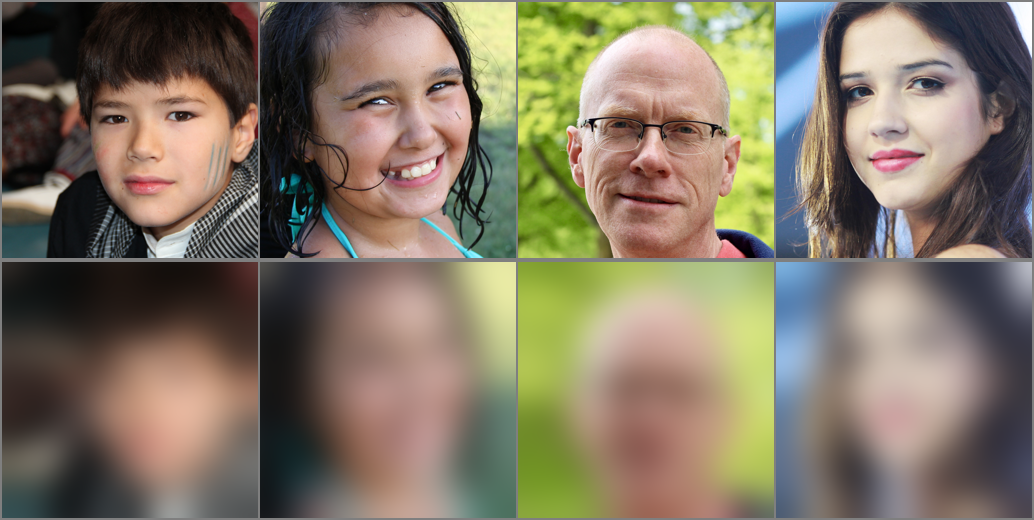

In [56]:
grid_true = make_grid(phase_real_img[:4], nrow = 4)
grid_cond = make_grid(processed[:4], nrow = 4)
grid = torch.cat((grid_true,grid_cond),dim=1)
display.display(to_pil_image(grid.add(1).div(2).cpu()))

## Training  

In [1]:
%cd ./StyleGAN-Canvas

/notebooks/StyleGAN-Canvas


In [2]:
outdir = '/notebooks/runs/ffhq-512-blur-f'
dataset_file = '/notebooks/StyleGAN-Canvas/ffhq-u-256x256.zip'
batch = 32
gamma = 2
cmax = 512
cbase = 16384
switch_to_vgg = 200

batch_gpu = 16
snap = 10

!python train.py --outdir={outdir} --cfg=stylegan-canvas-r --data={dataset_file} --gpus=1 --batch={batch} --gamma={gamma} --aug=ada --cmax={cmax} --cbase={cbase} --batch-gpu={batch_gpu} --switch-to-vgg={switch_to_vgg} --snap={snap}       






Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan_canvas.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 1024,
    "encode_rgb": 0,
    "blur_sigma": 0,
    "magnitude_ema_beta": 0.9988915792636801,
    "conv_kernel": 1,
    "connection_start": 0,
    "connection_end": 12,
    "connection_grow_from": 4,
    "num_appended_ws": 15,
    "use_radial_filters": true
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 0
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 16384,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
    